In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import seaborn as sns
import pandas as pd
import corner
import scipy.stats as stats
from tqdm import tqdm

from msc.plot_utils import set_size
from msc.config_utils import config

plt.style.use(['science', 'no-latex'])
plt.viridis()


/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 252x189 with 0 Axes>

In [ ]:
class PercentileOfScore(object):
    """a vectorized implementation of stats.percentileofscore"""
    def __init__(self, aList):
        self.a = np.array( aList )
        self.a.sort()
        self.n = float(len(self.a))
        self.pct = self.__rank_searchsorted_list
    # end def __init__

    def __rank_searchsorted_list(self, score_list):
        adx = np.searchsorted(self.a, score_list, side='right')
        pct = []
        for idx in adx:
            # Python 2.x needs explicit type casting float(int)
            pct.append( (float(idx) / self.n) * 100.0 )

        return pct
    # end def _rank_searchsorted_list
# end class PercentileOfScore

In [3]:
# generate data
n_samples = 100 * np.array([600, 400, 1])
centers = np.array([[0], [3], [5]])
X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=1, random_state=0)


In [4]:
# discretize for histogram
bins = np.linspace(-8, 8, 100, endpoint=True)
count, bins = np.histogram(X, bins=bins)


In [5]:
# fit density estimation
gmm = GaussianMixture(2)
gmm.fit(X)


GaussianMixture(n_components=2)

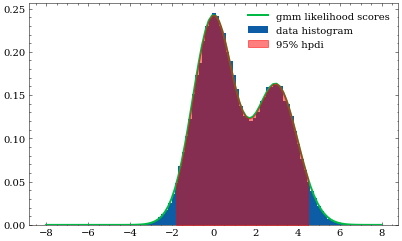

In [6]:
# plot density log likelihood
width = 478  # pt
fig, axes = plt.subplots(1, figsize=set_size(width))

theta = bins
scores = gmm.score_samples(theta.reshape(-1, 1))

axes.hist(X, bins=bins, label='data histogram', density=True, zorder=2)
axes.plot(theta, np.exp(scores), label='gmm likelihood scores', lw=2, zorder=2)

# plot highest posterior density interval 
ci = numpyro.diagnostics.hpdi(X, 0.95)
hdpi_x = np.linspace(ci[0], ci[1], 100).squeeze()
hdpi_scores = gmm.score_samples(hdpi_x.reshape(-1,1))

axes.fill_between(hdpi_x, np.exp(hdpi_scores), label="95% hpdi", color='r', alpha=0.5, zorder=3)
axes.legend()

plt.show()

In [7]:
ci

array([[-1.80219269],
       [ 4.48082753]])

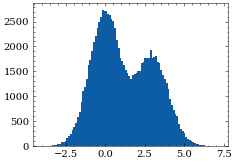

In [8]:
plt.hist(np.array(gmm.sample(100000)[0]).reshape(-1,1), bins=100);

sampling from gmm with mcmc

In [9]:
def mh_mcmc(N=int(1e5)):
  samples = []
  theta = np.array([0])
  for i in tqdm(range(N)):
    proposal_func = lambda x: stats.norm.rvs(loc=x, scale=1)
    theta_prime = np.array([proposal_func(theta)]).reshape(1,1)
    log_likelihood = gmm.score(theta_prime)
    r = np.random.uniform()
    if log_likelihood > np.log(r):
      theta = theta_prime
    samples.append(theta)
  return np.vstack(samples)

In [10]:
mcmc_samples = mh_mcmc()

100%|██████████| 100000/100000 [00:40<00:00, 2487.71it/s]


In [11]:
gmm_samples = gmm.sample(1e5)[0].reshape(-1, 1)

In [12]:
stats.describe(mcmc_samples)

DescribeResult(nobs=100000, minmax=(array([-3.18386844]), array([5.93239857])), mean=array([1.1098835]), variance=array([3.31410704]), skewness=array([0.32653776]), kurtosis=array([-0.81312218]))

In [13]:
stats.describe(gmm_samples)

DescribeResult(nobs=100000, minmax=(array([-4.12867947]), array([7.01468063])), mean=array([1.21354233]), variance=array([3.19118562]), skewness=array([0.23017725]), kurtosis=array([-0.87925169]))

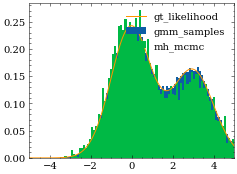

In [14]:
plt.hist(gmm_samples, bins=np.linspace(-5, 5, 100),  density=True, label='gmm_samples')
plt.hist(mcmc_samples, bins=np.linspace(-5, 5, 100), density=True, label='mh_mcmc');
# plt.yscale('log')
plt.xlim(-5, 5)
x = np.linspace(-5, 5, 100)
plt.plot(x, np.exp(gmm.score_samples(x.reshape(-1, 1))), label='gt_likelihood')
plt.legend()
plt.tight_layout();

In [15]:
mcmc_ci = numpyro.diagnostics.hpdi(mcmc_samples, 0.95)
mcmc_ci
# hdpi_x = np.linspace(ci[0], ci[1], 100).squeeze()
# hdpi_scores = gmm.score_samples(hdpi_x.reshape(-1,1))
# axes.fill_between(hdpi_x, np.exp(hdpi_scores), label="95% hpdi", color='r', alpha=0.5, zorder=3)

array([[-1.82450855],
       [ 4.59519436]])

In [16]:
gmm_ci = numpyro.diagnostics.hpdi(gmm_samples, 0.95)
gmm_ci

array([[-1.76706645],
       [ 4.50117051]])

In [17]:
mse = np.mean((mcmc_ci - gmm_ci)**2)
mse

0.006070039088767009

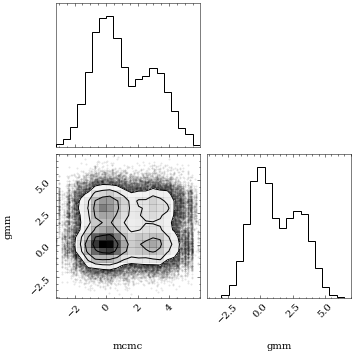

In [18]:
corner.corner(np.hstack([mcmc_samples, gmm_samples]), labels=['mcmc', 'gmm']);

In [19]:
stats.kstest(mcmc_samples.squeeze(), gmm_samples.squeeze())

KstestResult(statistic=0.03359000000000001, pvalue=1.897999435008942e-49)

In [20]:
1.63/np.sqrt(1e5)

0.005154512586074457

## convert to p-value

In [21]:
def bsle_transform(samples):
    samples = np.where(samples)

In [23]:
bsle_samples = mcmc_samples

In [24]:
values, counts = np.unique((np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])), return_counts=True)
values, counts

(array([False,  True]), array([ 5071, 94929]))

<BarContainer object of 2 artists>

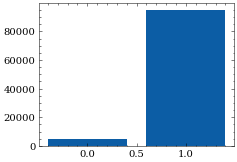

In [25]:
plt.bar(*np.unique((np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])), return_counts=True))

In [26]:
np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [28]:
inliers = mcmc_samples[np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1])]
outliers = mcmc_samples[np.logical_not(np.logical_and(mcmc_ci[0] < mcmc_samples, mcmc_samples < mcmc_ci[1]))]


In [35]:
outliers.shape

(5071,)

Text(0.5, 1.0, 'outliers')

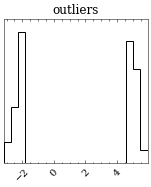

In [41]:
corner.corner(outliers.reshape(-1, 1));
plt.title('outliers')

Text(0.5, 1.0, 'inliers')

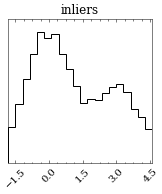

In [40]:
corner.corner(inliers.reshape(-1, 1));

plt.title('inliers')

In [31]:
len(outliers)

5071

In [75]:
samples_df = pd.DataFrame(mcmc_samples, columns=['x'])

In [76]:
samples_df['pdf_E'] = gmm.score_samples(samples_df['x'].to_numpy().reshape(-1, 1))

In [78]:
samples_df['P_E'] = PercentileOfScore(samples_df['pdf_E'].to_numpy()).pct(samples_df['pdf_E'].to_numpy())

In [93]:
samples_df['not_S'] = np.logical_and(mcmc_ci[0] < samples_df['x'].to_numpy(), samples_df['x'].to_numpy() < mcmc_ci[1])

In [99]:
samples_df.loc[samples_df['not_S'], 'P_E_|_not_S'] = PercentileOfScore(samples_df.loc[samples_df['not_S'], 'pdf_E'].to_numpy()).pct(samples_df.loc[samples_df['not_S'], 'pdf_E'].to_numpy())

In [89]:
samples_df.loc[]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [102]:
samples_df

,x,pdf_E,P_E,not_S,P_E_|_not_S
0,0.000000,-1.415679,99.572,True,99.549137
1,0.000000,-1.415679,99.572,True,99.549137
2,0.000000,-1.415679,99.572,True,99.549137
3,0.000000,-1.415679,99.572,True,99.549137
4,0.000000,-1.415679,99.572,True,99.549137
...,...,...,...,...,...
99995,1.050274,-1.852632,47.368,True,44.556458
99996,1.050274,-1.852632,47.368,True,44.556458
99997,1.050274,-1.852632,47.368,True,44.556458
99998,1.050274,-1.852632,47.368,True,44.556458


In [106]:
]

5000752.301999977